In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub


import warnings

sns.set_theme(style="whitegrid", palette="muted", font="sans-serif")
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [3]:
churn_palette = {"No": "#2b83ba", "Yes": "#d7191c"} # Just some colors for the visualizations]:

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
# Fix TotalCharges data type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges (new customers with tenure = 0)
df = df.dropna(subset=['TotalCharges'])

# Convert SeniorCitizen to readable form for EDA
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

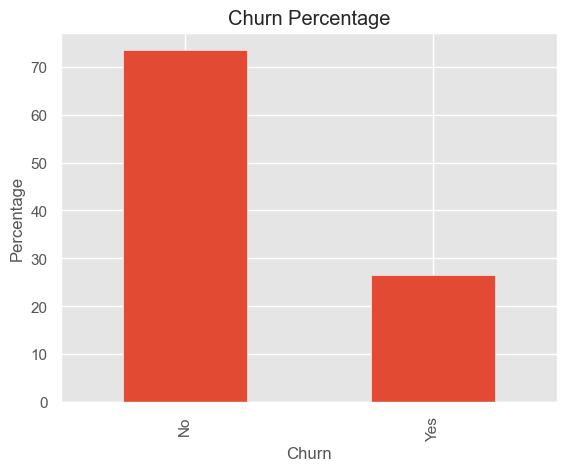

In [8]:
churn_pct = df["Churn"].value_counts(normalize=True) * 100
churn_pct.plot(kind="bar")

plt.title("Churn Percentage")
plt.ylabel("Percentage")
plt.show()

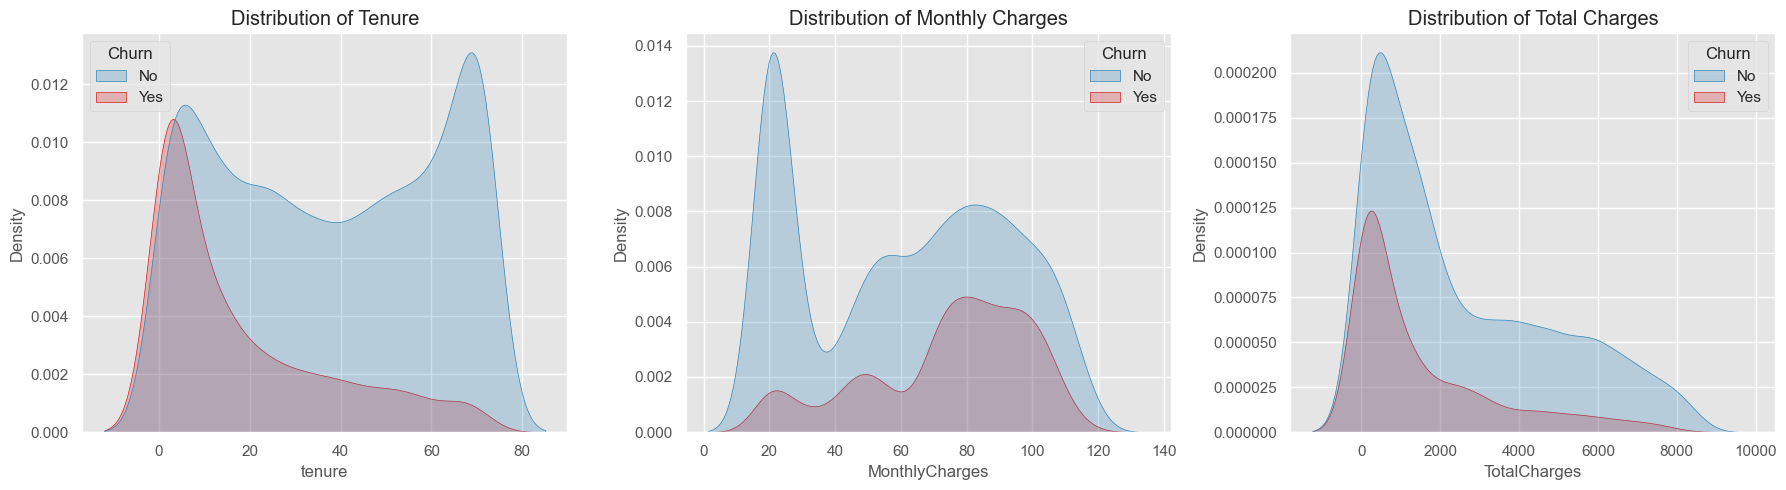

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, palette=churn_palette, ax=axes[0])
axes[0].set_title('Distribution of Tenure')

sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, palette=churn_palette, ax=axes[1])
axes[1].set_title('Distribution of Monthly Charges')

sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, palette=churn_palette, ax=axes[2])
axes[2].set_title('Distribution of Total Charges')

plt.tight_layout()
plt.show()

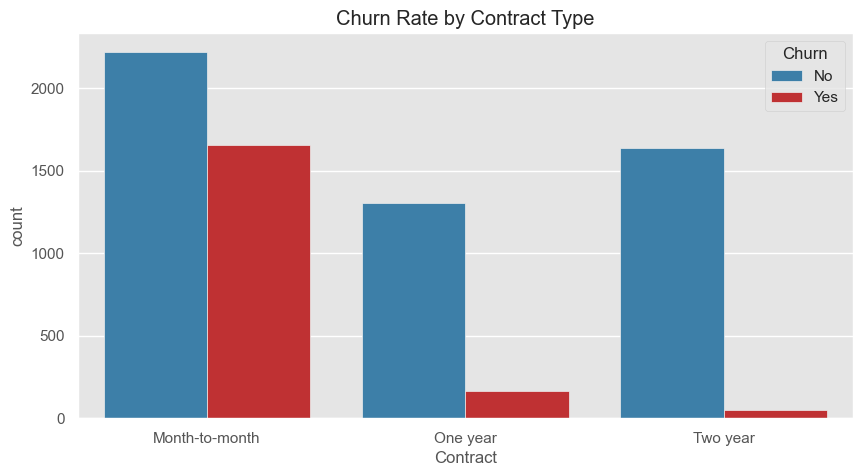

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Contract', hue='Churn', data=df, palette=churn_palette)
plt.title('Churn Rate by Contract Type')
plt.show()

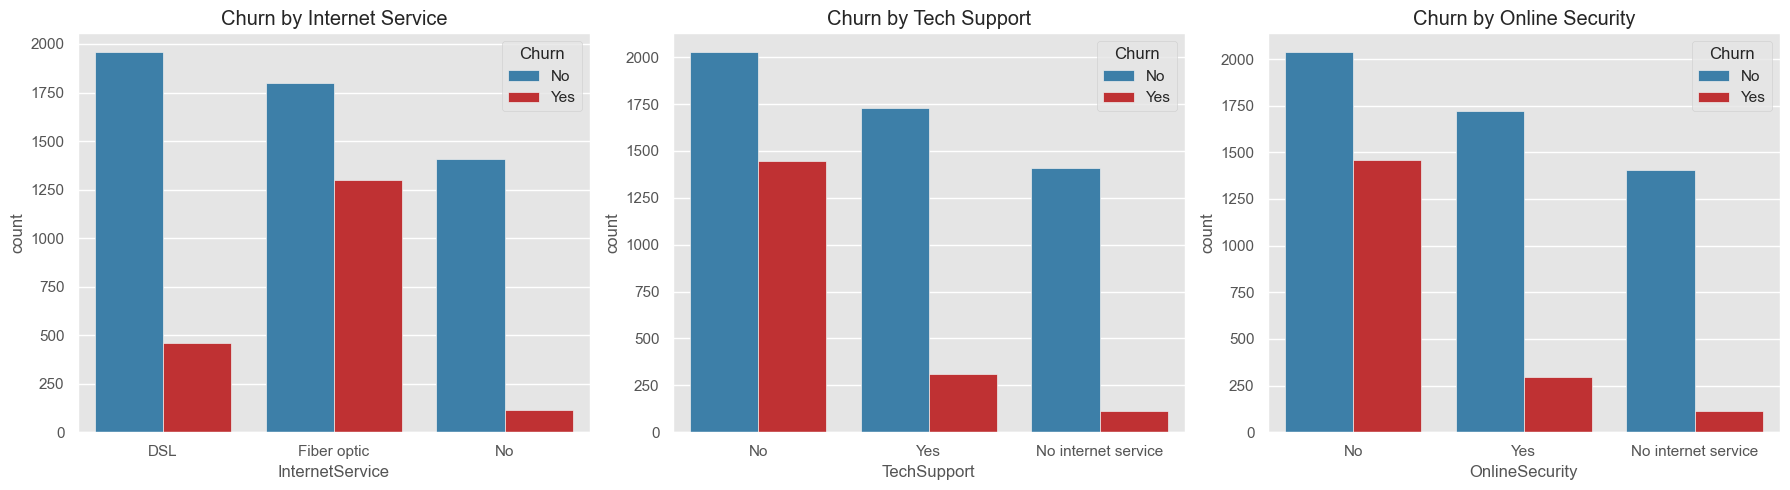

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='InternetService', hue='Churn', data=df, palette=churn_palette, ax=axes[0])
axes[0].set_title('Churn by Internet Service')

sns.countplot(x='TechSupport', hue='Churn', data=df, palette=churn_palette, ax=axes[1])
axes[1].set_title('Churn by Tech Support')

sns.countplot(x='OnlineSecurity', hue='Churn', data=df, palette=churn_palette, ax=axes[2])
axes[2].set_title('Churn by Online Security')

plt.tight_layout()
plt.show()

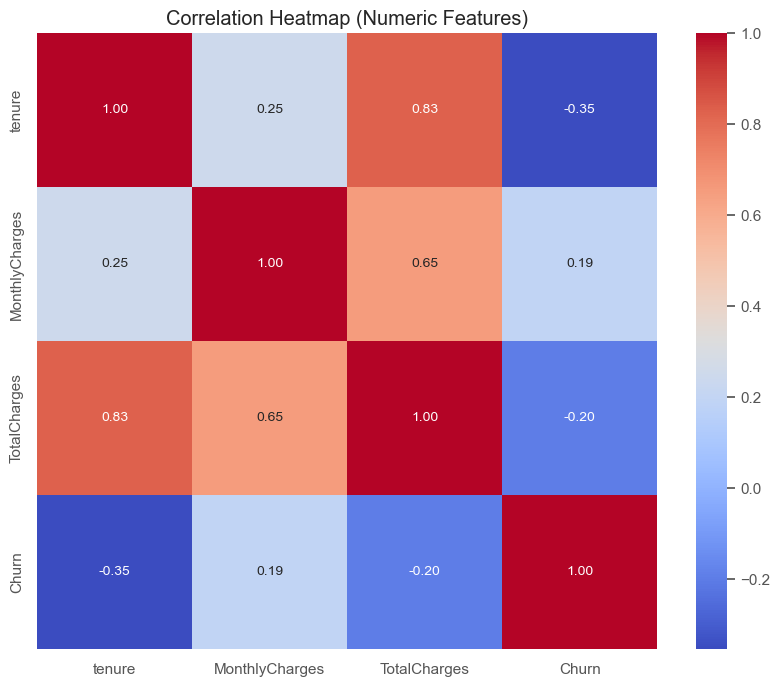

In [12]:
df_corr = df.copy()
df_corr['Churn'] = df_corr['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

numeric_df = df_corr.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

In [13]:

df = df.drop(columns="customerID") # Unuseful Features for prediction

In [14]:
binary_cols = []
for col in df.columns.to_list():
    if df[col].dtype == "object" and df[col].nunique() == 2: # If the col is a string and there are 2 different classes
        binary_cols.append(col)
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [15]:
ord_enc = OrdinalEncoder()
df[binary_cols] = ord_enc.fit_transform(df[binary_cols]).astype(int) # Transforms all binary columns in numbers. Example: Yes/No -> 0, 1

In [19]:
onehot_cols = []
for col in df.columns.to_list():
    if df[col].dtype == "object" and df[col].nunique() > 2: # If the col is a string and there are more than 2 classes.
        onehot_cols.append(col)
onehot_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [20]:
df = pd.get_dummies(df, columns=onehot_cols, drop_first=True, dtype=int) # One-Hot-Encode the selected columns
len(df.columns)

31

In [21]:
X = df.drop(columns="Churn")
y = df["Churn"]

In [37]:

def run_kfold(model):
    acc_scores = []
    recall_scores = []
    precision_scores = []

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        acc_scores.append(accuracy_score(y_val, preds))
        recall_scores.append(recall_score(y_val, preds))
        precision_scores.append(precision_score(y_val, preds))

    return (
        np.mean(acc_scores),
        np.mean(recall_scores),
        np.mean(precision_scores)
    )

In [46]:
log_reg_acc, log_reg_recall, log_reg_precision = run_kfold(
    LogisticRegression(C=0.04, solver='liblinear', penalty='l2', max_iter=5000)
)

In [47]:
dec_tree_acc, dec_tree_recall, dec_tree_precision = run_kfold(
    DecisionTreeClassifier(max_depth=6, min_samples_split=11, min_samples_leaf=6, criterion='entropy')
)

In [48]:
ranfor_acc, ranfor_recall, ranfor_precision = run_kfold(
    RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_leaf=4, max_features='sqrt', n_jobs=-1)
)

In [49]:
xgb_acc, xgb_recall, xgb_precision = run_kfold(
    XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss')
)

In [50]:
X.columns = [col.replace(' ', '_') for col in X.columns] # Needed for LGBM, else a lot of warnings will pop up

In [53]:
lgbm_acc, lgbm_recall, lgbm_precision = run_kfold(
    LGBMClassifier(n_estimators=100,learning_rate=0.05,num_leaves=31,colsample_bytree=0.8,subsample=0.8,subsample_freq=5,verbose=-1,n_jobs=1)
)

In [54]:
catboost_acc, catboost_recall, catboost_precision = run_kfold(
    CatBoostClassifier(iterations=500, learning_rate=0.03, depth=6, l2_leaf_reg=3, verbose=False)
)

In [55]:
comparison_df = pd.DataFrame({
    "Accuracy": [log_reg_acc, dec_tree_acc, ranfor_acc, xgb_acc, lgbm_acc, catboost_acc],
    "Precision": [log_reg_precision, dec_tree_precision, ranfor_precision, xgb_precision, lgbm_precision, catboost_precision],
    "Recall": [log_reg_recall, dec_tree_recall, ranfor_recall, xgb_recall, lgbm_recall, catboost_recall
               ]
}, index=[
    "Logistic Regression",
    "Decision Tree Classifier",
    "Random Forest Classifier",
    "XGB Classifier",
    "LGBM Classifier",
    "CatBoost Classifier"
])
comparison_df["F1"] = 2* ((comparison_df["Precision"] * comparison_df["Recall"]) / (comparison_df["Precision"] + comparison_df["Recall"]))
comparison_df = comparison_df.sort_values(by="F1", ascending=False)

In [57]:
comparison_df.style.highlight_max(color = '#2F4F4F', axis = 0)

,Accuracy,Precision,Recall,F1
Logistic Regression,0.803328,0.654593,0.551095,0.598402
XGB Classifier,0.807735,0.675589,0.532361,0.595483
LGBM Classifier,0.800766,0.658335,0.522205,0.582421
CatBoost Classifier,0.801622,0.661975,0.518459,0.581493
Random Forest Classifier,0.805319,0.678979,0.508289,0.581364
Decision Tree Classifier,0.785834,0.604570,0.557457,0.580059


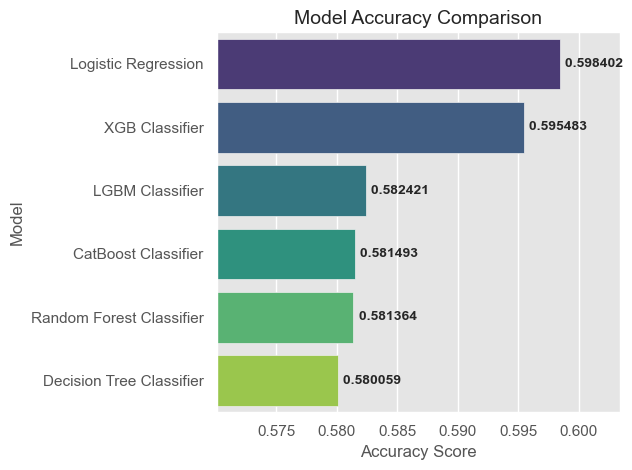

In [58]:
ax = sns.barplot(x='F1', y=comparison_df.index, data=comparison_df, palette='viridis')

plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)

plt.xlim(comparison_df['F1'].min() - 0.01, comparison_df['F1'].max() + 0.005)

for i, v in enumerate(comparison_df['F1']):
    ax.text(v + 0.0001, i, f' {v:.6f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

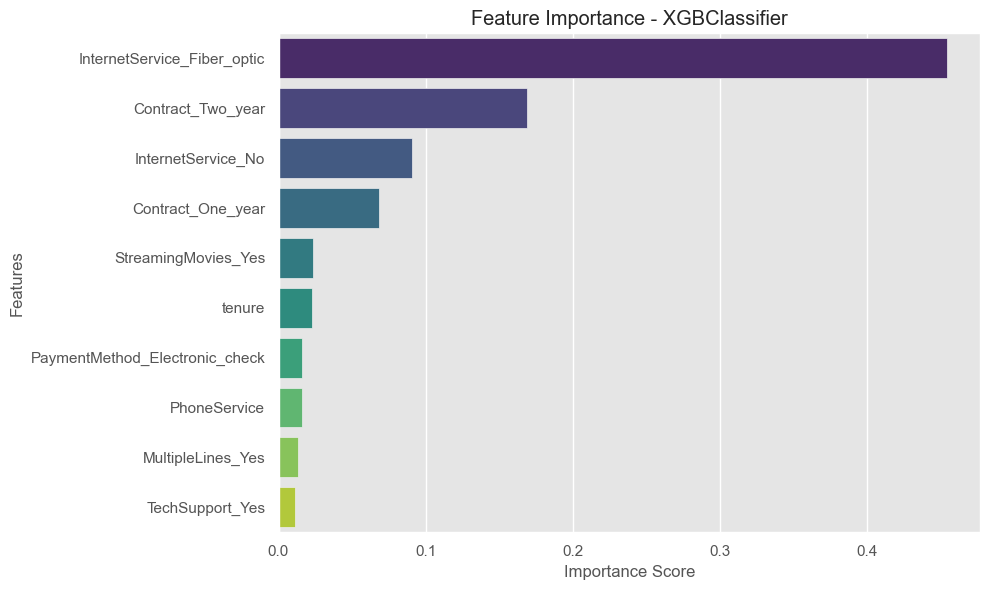

In [59]:
model = XGBClassifier().fit(X, y)
importance_df = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["Importance"]).sort_values(ascending=False, by="Importance")

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importance_df["Importance"][:10],
    y=importance_df.index[:10],
    palette="viridis"
)

plt.title("Feature Importance - XGBClassifier")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [60]:
# Final scaler (fit on full data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Final model
final_model = LogisticRegression(
    C=0.04,
    solver="liblinear",
    penalty="l2",
    max_iter=5000,
    class_weight="balanced"
)

final_model.fit(X_scaled, y)

LogisticRegression(C=0.04, class_weight='balanced', max_iter=5000,
                   solver='liblinear')

In [61]:
df["Churn_Prediction"] = final_model.predict(X_scaled)
df["Churn_Probability"] = final_model.predict_proba(X_scaled)[:, 1]

In [62]:
def risk_bucket(p):
    if p >= 0.7:
        return "High Risk"
    elif p >= 0.4:
        return "Medium Risk"
    else:
        return "Low Risk"

df["Churn_Risk"] = df["Churn_Probability"].apply(risk_bucket)

In [63]:
df[[
    "Churn",
    "Churn_Prediction",
    "Churn_Probability",
    "Churn_Risk"
]].head(10)

,Churn,Churn_Prediction,Churn_Probability,Churn_Risk
0,0,1,0.784641,High Risk
1,0,0,0.135311,Low Risk
2,1,1,0.521727,Medium Risk
3,0,0,0.105301,Low Risk
4,1,1,0.854964,High Risk
5,1,1,0.906707,High Risk
6,0,1,0.719774,High Risk
7,0,1,0.523451,Medium Risk
8,1,1,0.799186,High Risk
9,0,0,0.047989,Low Risk


In [64]:
df["Churn_Risk"].value_counts()

Churn_Risk
Low Risk       3570
High Risk      1755
Medium Risk    1707
Name: count, dtype: int64

In [65]:
pd.crosstab(df["Churn"], df["Churn_Prediction"], normalize="index")

Churn_Prediction,0,1
Churn,,
0,0.730002,0.269998
1,0.196362,0.803638


In [67]:
active_customers = df[df["Churn"] == 0].copy()

In [68]:
len(active_customers)

5163

In [69]:
active_customers["Churn_Risk"].value_counts()

Churn_Risk
Low Risk       3329
Medium Risk    1190
High Risk       644
Name: count, dtype: int64

In [70]:
active_customers.sort_values(
    "Churn_Probability",
    ascending=False
).head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Prediction,Churn_Probability,Churn_Risk
3159,1,1,0,0,3,1,1,94.85,335.75,0,...,0,1,0,0,0,1,0,1,0.935444,High Risk
3346,0,1,0,0,2,1,1,84.05,186.05,0,...,0,1,0,0,0,1,0,1,0.921831,High Risk
293,0,1,0,0,6,1,1,89.35,567.80,0,...,0,1,0,0,0,1,0,1,0.914535,High Risk
4618,1,1,0,0,4,1,1,94.75,422.40,0,...,0,1,0,0,0,1,0,1,0.914392,High Risk
935,0,1,1,0,4,1,1,83.25,308.05,0,...,0,0,0,0,0,1,0,1,0.914064,High Risk
5019,1,1,0,0,14,1,1,95.60,1273.30,0,...,0,1,0,0,0,1,0,1,0.912924,High Risk
4039,1,0,0,0,7,1,1,94.10,701.30,0,...,0,1,0,0,0,1,0,1,0.911766,High Risk
352,0,1,0,0,7,1,1,89.15,574.35,0,...,0,1,0,0,0,1,0,1,0.911480,High Risk
4150,1,1,1,0,7,1,1,89.00,605.45,0,...,0,1,0,0,0,1,0,1,0.908394,High Risk
1725,0,1,0,0,17,1,1,94.20,1608.15,0,...,0,1,0,0,0,1,0,1,0.907132,High Risk


In [73]:
active_customers.columns.tolist()

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges',
 'Churn',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'Churn_Prediction',
 'Churn_Probability',
 'Churn_Risk']

In [74]:
final_output = active_customers[[
    "Churn_Probability",
    "Churn_Risk",
    "MonthlyCharges",
    "tenure",
    "Contract_One year",
    "Contract_Two year",
    "InternetService_Fiber optic",
    "InternetService_No"
]].sort_values("Churn_Probability", ascending=False)

In [75]:
final_output.to_csv("churn_retention_targets.csv", index=False)